In [6]:
%load_ext autoreload
%autoreload 2

from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pykalman
import pytz
import statsmodels.api as sm
from datetime import datetime
from matplotlib import style
from pykalman import KalmanFilter
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from tqdm import tqdm_notebook
from trading_calendars.always_open import AlwaysOpenCalendar
from sklearn.linear_model import RANSACRegressor

import utils

style.use("ggplot")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Research Hyperparameters

# Utils

In [7]:
def research_serieses_for_cointegration(data, det_order, k_ar_diff):
    johansen_results = coint_johansen(data.values, det_order=det_order, k_ar_diff=k_ar_diff)
    
    print("Eigen values:", johansen_results.eig)
    print("Eigen vectors:", johansen_results.evec)
    print()
    
    print("Trace Test")
    print("Trace Statistics:", johansen_results.lr1)
    print("CV for Trace Statistics:", johansen_results.cvt)
    print()
    
    print("Eigen Test")
    print("Eigen Statistics:", johansen_results.lr2)
    print("CV for Eigen Statistics:", johansen_results.cvm)

In [8]:
RESEARCH_START_DATE = pd.Timestamp("2018-06-15")
COINTEGRATION_RESEARCH_DATE = pd.Timestamp("2018-08-01")

# USD Market

In [9]:
utils.list_market("candles", "USD");

ETH-USD.csv
BTC-USD.csv
ETC-USD.csv
ZRX-USD.csv
BCH-USD.csv
LTC-USD.csv


In [10]:
BTC_MIN = 0.001
BCH_MIN = 0.01
ETH_MIN = 0.01
LTC_MIN = 0.1
data = utils.combine_market_data("candles/", "USD", "open", True,
                                 file_names_to_exclude=["ZRX-USD.csv", "ETC-USD.csv",])
data.interpolate(inplace=True, method="linear")
data = data.loc[:]
data.head()

data["ETH-USD"] *= ETH_MIN
data["BTC-USD"] *= BTC_MIN
data["BCH-USD"] *= BCH_MIN
data["LTC-USD"] *= LTC_MIN

data = data.apply(lambda x: round(x, 3))

['ETH-USD.csv', 'BTC-USD.csv', 'BCH-USD.csv', 'LTC-USD.csv']


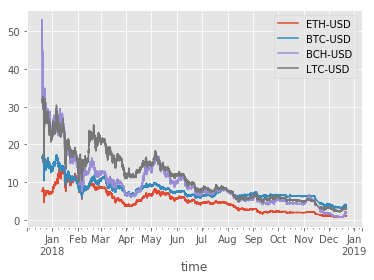

In [11]:
data.plot()

In [24]:
list(combinations(data.columns.values, 3))

[('ETH-USD', 'BTC-USD', 'BCH-USD'),
 ('ETH-USD', 'BTC-USD', 'LTC-USD'),
 ('ETH-USD', 'BCH-USD', 'LTC-USD'),
 ('BTC-USD', 'BCH-USD', 'LTC-USD')]

In [30]:
research_serieses_for_cointegration(data, 0, 1)

Eigen values: [3.58661006e-04 5.98296340e-05 3.15912014e-05 5.90537905e-06]
Eigen vectors: [[-0.32334648 -0.22106463 -0.52062458 -0.40969817]
 [-0.66619456  1.19009537 -0.36544622  0.28925223]
 [ 0.46993413 -0.21410572 -0.15314237  0.01811255]
 [ 0.00764147 -0.10102263  0.51325974 -0.08242856]]

Trace Test
Trace Statistics: [241.32272452  51.50177606  19.84173882   3.12486417]
CV for Trace Statistics: [[44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Eigen Test
Eigen Statistics: [189.82094846  31.66003724  16.71687465   3.12486417]
CV for Eigen Statistics: [[25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [ ]:
data.c

In [13]:
data.columns

Index(['ETH-USD', 'BTC-USD', 'BCH-USD', 'LTC-USD'], dtype='object')

In [16]:
utils.check_serieses_pairs_for_cointegration(data)

--------------------------
Pair ETH-USD and BTC-USD
Test Statistic: -3.6010039894431793
P-Value: 0.024431604828681747
Critical values: [-3.8964607  -3.33614155 -3.04445802]
--------------------------
Pair ETH-USD and BCH-USD
Test Statistic: -8.789301710117298
P-Value: 3.0065212803173933e-13
Critical values: [-3.8964607  -3.33614155 -3.04445802]
--------------------------
Pair ETH-USD and LTC-USD
Test Statistic: -4.3544196656195435
P-Value: 0.0021029990964582224
Critical values: [-3.8964607  -3.33614155 -3.04445802]
--------------------------
Pair BTC-USD and BCH-USD
Test Statistic: -9.376181386652615
P-Value: 9.52028723076253e-15
Critical values: [-3.8964607  -3.33614155 -3.04445802]
--------------------------
Pair BTC-USD and LTC-USD
Test Statistic: -3.6749479764639563
P-Value: 0.019729055901197924
Critical values: [-3.8964607  -3.33614155 -3.04445802]
--------------------------
Pair BCH-USD and LTC-USD
Test Statistic: -9.001805395841451
P-Value: 8.612354379027667e-14
Critical values:

Researching Pair BTC-USD and BCH-USD
Prices OLS results:
const: 4.115236473756881 || BCH-USD 0.39586311527960694


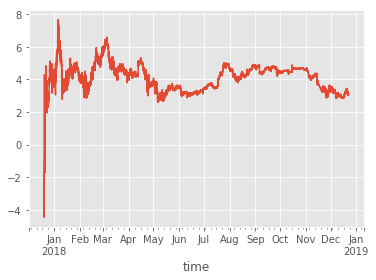

Diff of Cointegrating Series OLS Results:
const: 0.0011926821029275656 || -0.00029036137086321735
Mean-Reverse Half-life: 2387.188001280209


In [20]:
utils.research_pair_trading_opportunity(data["BTC-USD"], data["BCH-USD"])

In [26]:
model = RANSACRegressor(min_samples=0.9)
model = model.fit(sm.add_constant(data["BTC-USD"].values), data["LTC-USD"].values)

In [27]:
model.score(sm.add_constant(data["BTC-USD"].values), data["LTC-USD"].values)

0.8807724668971922

In [28]:
model.estimator_.coef_

array([0.        , 2.35169605])

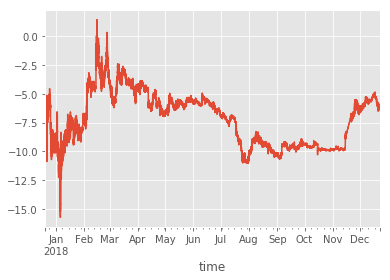

In [29]:
(data["LTC-USD"] - 2.35169605 * data["BTC-USD"]).plot()

# Log Prices Research

In [9]:
BTC_MIN = 0.001
BCH_MIN = 0.01
ETH_MIN = 0.01
LTC_MIN = 0.1
data = utils.combine_market_data("candles/", "USD", "open", True,
                                 file_names_to_exclude=["ZRX-USD.csv", "ETC-USD.csv",])
data.interpolate(inplace=True, method="linear")
data = data.loc[:COINTEGRATION_RESEARCH_DATE]
data.head()

data["ETH-USD"] *= ETH_MIN
data["BTC-USD"] *= BTC_MIN
data["BCH-USD"] *= BCH_MIN
data["LTC-USD"] *= LTC_MIN

data = data.apply(lambda x: round(x, 3))

['ETH-USD.csv', 'BTC-USD.csv', 'BCH-USD.csv', 'LTC-USD.csv']


In [12]:
log_prices = np.log(data)

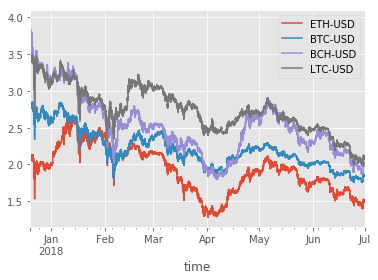

In [13]:
log_prices.plot()

In [14]:
utils.check_serieses_pairs_for_cointegration(log_prices)

--------------------------
Pair ETH-USD and BTC-USD
Test Statistic: -2.4850127317426076
P-Value: 0.28571857575080645
Critical values: [-3.89647942 -3.33615199 -3.04446526]
--------------------------
Pair ETH-USD and BCH-USD
Test Statistic: -3.7875165422560517
P-Value: 0.014084130060981349
Critical values: [-3.89647942 -3.33615199 -3.04446526]
--------------------------
Pair ETH-USD and LTC-USD
Test Statistic: -2.31025818824124
P-Value: 0.36844535975982595
Critical values: [-3.89647942 -3.33615199 -3.04446526]
--------------------------
Pair BTC-USD and BCH-USD
Test Statistic: -3.9744002664025238
P-Value: 0.007808235095487499
Critical values: [-3.89647942 -3.33615199 -3.04446526]
--------------------------
Pair BTC-USD and LTC-USD
Test Statistic: -3.6025316903960616
P-Value: 0.02432543014103177
Critical values: [-3.89647942 -3.33615199 -3.04446526]
--------------------------
Pair BCH-USD and LTC-USD
Test Statistic: -3.1686308777812315
P-Value: 0.07533228899435733
Critical values: [-3.89

Researching Pair ETH-USD and BCH-USD
Prices OLS results:
const: 0.4100762840506959 || BCH-USD 0.6009323259868581


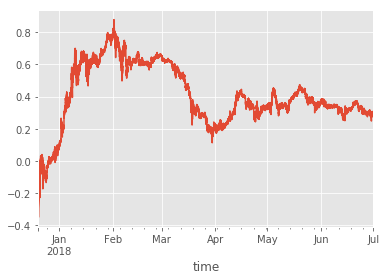

Diff of Cointegrating Series OLS Results:
const: 2.4406975926713235e-05 || -5.661596028271454e-05
Mean-Reverse Half-life: 12242.96430014931


In [18]:
utils.research_pair_trading_opportunity(log_prices["ETH-USD"], log_prices["BCH-USD"])

# Kalman Filter

In [53]:
BTC_MIN = 0.001
BCH_MIN = 0.01
ETH_MIN = 0.01
LTC_MIN = 0.1
data = utils.combine_market_data("candles/", "USD", "open", True,
                                 file_names_to_exclude=["ZRX-USD.csv", "ETC-USD.csv",])
data.interpolate(inplace=True, method="linear")
data = data.loc[:COINTEGRATION_RESEARCH_DATE]
data.head()

data["ETH-USD"] *= ETH_MIN
data["BTC-USD"] *= BTC_MIN
data["BCH-USD"] *= BCH_MIN
data["LTC-USD"] *= LTC_MIN

data = data.apply(lambda x: round(x, 3))

['ETH-USD.csv', 'BTC-USD.csv', 'BCH-USD.csv', 'LTC-USD.csv']


In [63]:
x = data["LTC-USD"].values
y = data["BTC-USD"].values
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

In [65]:
state_means, state_covs = kf.filter(y)

In [75]:
state_means.shape

(322481, 2)

In [133]:
obs_mat[0][0]

array([32.014,  1.   ])

In [134]:
state_covs[0]

array([[0.00183163, 0.00183163],
       [0.00183163, 0.00183163]])

In [135]:
obs_mat[0][0].T.dot(state_covs[0])

array([0.0604694, 0.0604694])

In [122]:
state_covs[0]

array([[0.00183163, 0.00183163],
       [0.00183163, 0.00183163]])

In [148]:
prediction_stds = np.empty(shape=len(y))
for x_index, x_val in enumerate(obs_mat):
    x_val = x_val[0]
    state_cov = state_covs[x_index]
    prediction_stds[x_index] = np.sqrt(x_val.dot(state_covs[x_index]).dot(x_val.T))

In [149]:
prediction_stds

array([1.41291781, 1.09714797, 1.01437973, ..., 0.57107657, 0.57047903,
       0.57015943])

In [105]:
state_means.shape

(322481, 2)

In [79]:
coint_series = y - state_means[:, 0] * x - state_means[:, 1]

In [160]:
coint_stds = pd.Series(coint_series).rolling(120).std()

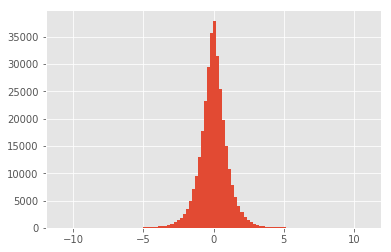

In [161]:
plt.hist(coint_series / coint_stds, bins=100);

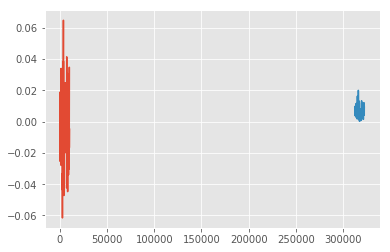

In [141]:
plt.plot(coint_series[-10000:])
plt.plot(pd.Series(coint_series).rolling(60).std()[-10000:])

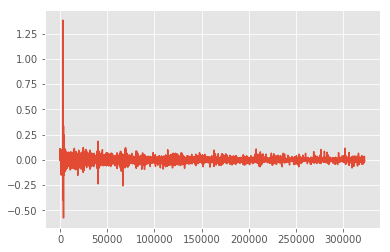

In [82]:
plt.plot(coint_series)

# Check Daily Cointegration

In [181]:
for currency in utils.list_market("candles", "USD", is_print=False):
    print(currency)
    minute_prices = pd.read_csv(f"candles/{currency}", index_col="time", parse_dates=["time"])

    daily_open = minute_prices["open"].resample("1d").first()
    daily_high = minute_prices["high"].resample("1d").max()
    daily_low = minute_prices["low"].resample("1d").min()
    daily_close = minute_prices["close"].resample("1d").last()
    daily_volume = minute_prices["volume"].resample("1d").sum()

    daily_data = pd.DataFrame([daily_open, daily_high, daily_low, daily_close, daily_volume]).T
    daily_data.to_csv(f"daily_bars/{currency}")

ETH-USD.csv
BTC-USD.csv
ETC-USD.csv
ZRX-USD.csv
BCH-USD.csv
LTC-USD.csv


In [3]:
BTC_MIN = 0.001
BCH_MIN = 0.01
ETH_MIN = 0.01
LTC_MIN = 0.1
data = utils.combine_market_data("daily_bars/", "USD", "open", True,
                                 file_names_to_exclude=["ZRX-USD.csv", "ETC-USD.csv",])
data.interpolate(inplace=True, method="linear")
data = data.loc[RESEARCH_START_DATE:COINTEGRATION_RESEARCH_DATE]
data.head()

data["ETH-USD"] *= ETH_MIN
data["BTC-USD"] *= BTC_MIN
data["BCH-USD"] *= BCH_MIN
data["LTC-USD"] *= LTC_MIN

data = data.apply(lambda x: round(x, 3))

['ETH-USD.csv', 'BTC-USD.csv', 'BCH-USD.csv', 'LTC-USD.csv']


NameError: name 'RESEARCH_START_DATE' is not defined

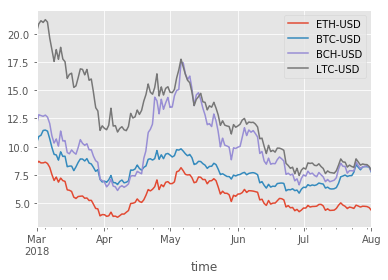

In [195]:
data.plot()

In [196]:
research_serieses_for_cointegration(data, 0, 1)

Eigen values: [6.47284368e-03 4.63063669e-03 1.26046770e-03 8.72201107e-08]
Eigen vectors: [[ 1.58185839 -1.42156618 -0.73850591  0.6803989 ]
 [-0.30653207  0.18978997  1.74174383  1.08706777]
 [-0.47124559  0.66113501 -0.25885615  0.00823438]
 [-0.31325998 -0.17230444 -0.25257397 -0.46285346]]

Trace Test
Trace Statistics: [2.73121195e+03 1.30048606e+03 2.77899366e+02 1.92162484e-02]
CV for Trace Statistics: [[44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Eigen Test
Eigen Statistics: [1.43072589e+03 1.02258669e+03 2.77880150e+02 1.92162484e-02]
CV for Eigen Statistics: [[25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [197]:
utils.check_serieses_pairs_for_cointegration(data)

--------------------------
Pair ETH-USD and BTC-USD
Test Statistic: 3.4624029881147598
P-Value: 1.0
Critical values: [-3.89648971 -3.33615773 -3.04446925]
--------------------------
Pair ETH-USD and BCH-USD
Test Statistic: -24.705660565143937
P-Value: 0.0
Critical values: [-3.89648971 -3.33615773 -3.04446925]
--------------------------
Pair ETH-USD and LTC-USD
Test Statistic: -2.9535093181867436
P-Value: 0.12167404655471109
Critical values: [-3.89648971 -3.33615773 -3.04446925]
--------------------------
Pair BTC-USD and BCH-USD
Test Statistic: -10.801862734175112
P-Value: 2.522491787727642e-18
Critical values: [-3.89648971 -3.33615773 -3.04446925]
--------------------------
Pair BTC-USD and LTC-USD
Test Statistic: 10.24186198798346
P-Value: 1.0
Critical values: [-3.89648971 -3.33615773 -3.04446925]
--------------------------
Pair BCH-USD and LTC-USD
Test Statistic: -3.2825622403105372
P-Value: 0.05717124157363737
Critical values: [-3.89648971 -3.33615773 -3.04446925]


Researching Pair ETH-USD and BCH-USD
Prices OLS results:
const: 1.5579294434083946 || 0.4113988057104392


/Users/nialeksandrov/virtualenvs/trading/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


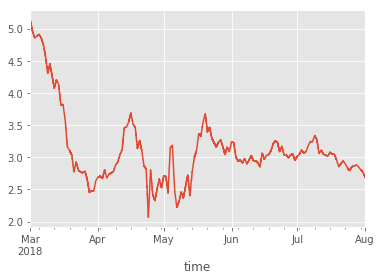

Diff of Cointegrating Series OLS Results:
const: 8.129669741292357e-05 || -2.965981158254667e-05
Mean-Reverse Half-life: 23369.9117956578


In [198]:
utils.research_pair_trading_opportunity(data["ETH-USD"], data["BCH-USD"])

Researching Pair BCH-USD and LTC-USD
Prices OLS results:
const: 3.46458572000052 || 0.5108354541610038


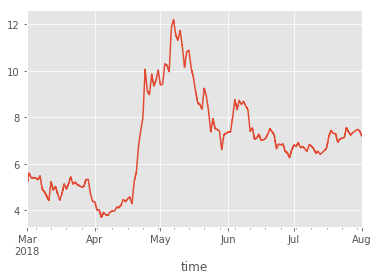

Diff of Cointegrating Series OLS Results:
const: 2.3068148255889848e-05 || -1.9541996264505525e-06
Mean-Reverse Half-life: 354696.1994967325


In [199]:
utils.research_pair_trading_opportunity(data["BCH-USD"], data["LTC-USD"])

# Check Monthly Cointegration

In [142]:
BTC_MIN = 0.001
BCH_MIN = 0.01
ETH_MIN = 0.01
LTC_MIN = 0.1
data = utils.combine_market_data("candles/", "USD", "open", True,
                                 file_names_to_exclude=["ZRX-USD.csv", "ETC-USD.csv",])
data.interpolate(inplace=True, method="linear")

data["ETH-USD"] *= ETH_MIN
data["BTC-USD"] *= BTC_MIN
data["BCH-USD"] *= BCH_MIN
data["LTC-USD"] *= LTC_MIN

data = data.apply(lambda x: round(x, 3))

In [143]:
for month_index in range(3, 8):
    start_date = pd.Timestamp(f"2018-0{month_index}-01")
    end_date = pd.Timestamp(f"2018-0{month_index + 1}-01")
    print("----------------------------------")
    print("----------------------------------")
    print("----------------------------------")
    print(f"RESEARCH MONTH {start_date}")
    selected_data = data.loc[start_date:end_date]
    utils.check_serieses_pairs_for_cointegration(selected_data, is_print_test_statistic=False)

----------------------------------
----------------------------------
----------------------------------
RESEARCH MONTH 2018-03-01 00:00:00
--------------------------
Pair ETH-USD and BTC-USD
Test Statistic: -2.4297877839168476
P-Value: 0.31087966896280833
Critical values: [-3.89668536 -3.33626688 -3.04454501]
--------------------------
Pair ETH-USD and BCH-USD
Test Statistic: -2.184300724384685
P-Value: 0.4324734584239959
Critical values: [-3.89668536 -3.33626688 -3.04454501]
--------------------------
Pair ETH-USD and LTC-USD
Test Statistic: -3.055275029909207
P-Value: 0.09764374107140344
Critical values: [-3.89668536 -3.33626688 -3.04454501]
--------------------------
Pair BTC-USD and BCH-USD
Test Statistic: -3.388925088710771
P-Value: 0.04359552989060736
Critical values: [-3.89668536 -3.33626688 -3.04454501]
--------------------------
Pair BTC-USD and LTC-USD
Test Statistic: -2.509483844760176
P-Value: 0.27490245632426036
Critical values: [-3.89668536 -3.33626688 -3.04454501]
-----

# Dollar Bars Research

In [201]:
RESEARCH_START_DATE = pd.Timestamp("2018-03-01")
COINTEGRATION_RESEARCH_DATE = pd.Timestamp("2020-08-01")

In [202]:
currency1, currency2 = utils.sample_pair_as_dollar_bars("candles/BCH-USD.csv", "candles/LTC-USD.csv", 
                                                        RESEARCH_START_DATE, COINTEGRATION_RESEARCH_DATE,
                                                        1e6)

In [205]:
data = pd.concat([currency1["open"], currency2["open"]], axis=1, join="outer")
data.columns = ["ETH-USD", "BCH-USD"]
data *= [BCH_MIN, LTC_MIN]

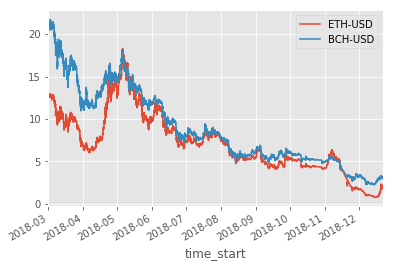

In [206]:
data.plot()

In [207]:
utils.check_serieses_pairs_for_cointegration(data)

--------------------------
Pair ETH-USD and BCH-USD
Test Statistic: -1.706452444062731
P-Value: 0.6739506576467152
Critical values: [-3.89757822 -3.33676489 -3.04489067]


Researching Pair ETH-USD and BCH-USD
Prices OLS results:
const: 1.4824727263944195 || 0.6613246349688049


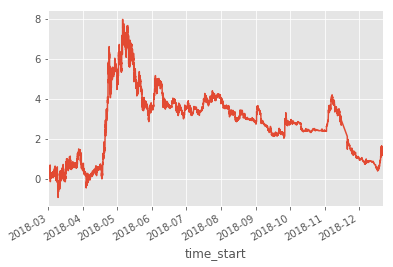

Diff of Cointegrating Series OLS Results:
const: 0.0018492439999374139 || -0.0005769331080087045
Mean-Reverse Half-life: 1201.4342233753162


In [208]:
utils.research_pair_trading_opportunity(data["ETH-USD"], data["BCH-USD"])